In [8]:
import pandas as pd

# Load dataset
df = pd.read_csv("Confirmed Exoplanet (Planetary System).csv")
df.columns


Index(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum',
       'discoverymethod', 'disc_year', 'disc_facility', 'soltype',
       'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2

**Check Availability of required features**

In [9]:
# Mapping required features to actual dataset column names
required_cols = {
    "planet_radius": "pl_rade",
    "planet_mass": "pl_bmasse",
    "surface_temperature": "pl_eqt",
    "orbital_period": "pl_orbper",
    "distance_from_star": "pl_orbsmax",
    "host_star_type": "st_spectype",
    "host_star_temperature": "st_teff",
    "host_star_metallicity": "st_met",
}

# Check availability
available = {k: v for k, v in required_cols.items() if v in df.columns}
# Extract available columns
extract_cols = list(available.values())
extracted_df = df[extract_cols]

print("\nExtracted Feature Dataset (first 5 rows):")
print(extracted_df.head())


Extracted Feature Dataset (first 5 rows):
   pl_rade   pl_bmasse  pl_eqt  pl_orbper  pl_orbsmax st_spectype  st_teff  \
0      NaN  6165.60000     NaN  326.03000       1.290      G8 III   4742.0   
1      NaN  5434.70000     NaN        NaN       1.210         NaN      NaN   
2      NaN  4914.89849     NaN  323.21000       1.178      G8 III   4874.0   
3      NaN  4684.81420     NaN  516.21997       1.530         NaN   4213.0   
4      NaN  3337.07000     NaN  516.22000       1.540      K4 III   4340.0   

   st_met  
0   -0.35  
1     NaN  
2   -0.26  
3   -0.02  
4    0.04  


**Drop the rows  with ANY null values**

In [10]:

clean_df = extracted_df.dropna()
print("\nRows before cleaning:", len(extracted_df))
print("Rows after cleaning:", len(clean_df))



Rows before cleaning: 38170
Rows after cleaning: 591


**Save clean dataset**

In [11]:

output_path = "clean_exoplanet_features.csv"
clean_df.to_csv(output_path, index=False)
print(f"\nClean dataset saved successfully to: {output_path}")
print(clean_df.head())


Clean dataset saved successfully to: clean_exoplanet_features.csv
     pl_rade   pl_bmasse  pl_eqt     pl_orbper  pl_orbsmax st_spectype  \
191    2.230    16.30000   546.0  4.168550e+01      0.2410           G   
236   12.442  2002.31896   434.0  4.020000e+08   7506.0000        M3 V   
247   10.870   874.00000   600.0  1.324060e+01      0.1055        K1 V   
250   16.030   740.51000  1657.0  2.994330e+00      0.0436        F6 V   
266    9.920   415.70400  1700.0  4.035190e+00      0.0510        G0 V   

     st_teff  st_met  
191   5766.0   -0.15  
236   3406.0    0.00  
247   5075.0    0.26  
250   6440.0   -0.03  
266   5945.0    0.01  


**Load clean dataset**

In [12]:
import pandas as pd
import numpy as np

df = pd.read_csv("clean_exoplanet_features.csv")


**Outlier handling using IQR (safe & standard)**

In [17]:
numeric_cols = [
    "pl_rade",
    "pl_bmasse",
    "pl_eqt",
    "pl_orbper",
    "pl_orbsmax",
    "st_teff",
    "st_met"
]


In [18]:
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [19]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in numeric_cols:
    df = remove_outliers_iqr(df, col)


**Encode categorical features (One-Hot Encoding)**

In [21]:
df = pd.get_dummies(df, columns=["st_spectype"], prefix="star")


**Feature Engineering**

**A.Habitability Score Index**

In [23]:

# Normalize needed columns

# Planet radius normalization (Earth-like ≈ 1)
df["radius_norm"] = 1 - abs(df["pl_rade"] - 1) / df["pl_rade"].max()

# Surface temperature normalization (Earth ≈ 288 K)
df["temp_norm"] = 1 - abs(df["pl_eqt"] - 288) / df["pl_eqt"].max()

# Distance from star normalization (Earth ≈ 1 AU)
df["distance_norm"] = 1 - abs(df["pl_orbsmax"] - 1) / df["pl_orbsmax"].max()

# Habitability Score Index

df["habitability_index"] = (
    0.4 * df["radius_norm"] +
    0.4 * df["temp_norm"] +
    0.2 * df["distance_norm"]
)

# Ensure values stay between 0 and 1
df["habitability_index"] = df["habitability_index"].clip(0, 1)


**B. Stellar Compatibility Index**

In [24]:
# -----------------------------
# Stellar Compatibility Index
# -----------------------------

# Star temperature score (Sun ≈ 5778 K)
df["star_temp_score"] = 1 - abs(df["st_teff"] - 5778) / df["st_teff"].max()

# Star metallicity score (Solar ≈ 0)
df["star_met_score"] = 1 - abs(df["st_met"]) / df["st_met"].abs().max()

# Weighted stellar compatibility index
df["stellar_compatibility_index"] = (
    0.6 * df["star_temp_score"] +
    0.4 * df["star_met_score"]
)

# Ensure score stays within [0, 1]
df["stellar_compatibility_index"] = df["stellar_compatibility_index"].clip(0, 1)


**Normalize numerical features**

In [26]:
from sklearn.preprocessing import StandardScaler

scale_cols = [
     "pl_rade",
    "pl_bmasse",
    "pl_eqt",
    "pl_orbper",
    "pl_orbsmax",
    "st_teff",
    "st_met"]

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])


**Validate data quality (Statistics & Visualization)**

            pl_rade     pl_bmasse        pl_eqt   pl_orbper    pl_orbsmax  \
count  3.910000e+02  3.910000e+02  3.910000e+02  391.000000  3.910000e+02   
mean  -2.180694e-16  1.181209e-16 -1.362934e-17    0.000000 -6.814668e-17   
std    1.001281e+00  1.001281e+00  1.001281e+00    1.001281  1.001281e+00   
min   -1.325696e+00 -9.210983e-01 -1.900858e+00   -1.600289 -2.093649e+00   
25%   -1.068774e+00 -8.725060e-01 -8.899774e-01   -0.659881 -7.016911e-01   
50%    2.269204e-01 -3.443525e-01 -6.363076e-02   -0.225138 -3.417635e-02   
75%    8.371911e-01  6.553126e-01  7.556185e-01    0.415369  5.621121e-01   
max    2.013961e+00  3.180098e+00  2.633403e+00    2.988950  2.471189e+00   

            st_teff        st_met  radius_norm   temp_norm  distance_norm  \
count  3.910000e+02  3.910000e+02   391.000000  391.000000     391.000000   
mean  -1.839960e-16 -3.634490e-17     0.629968    0.632592      -9.376789   
std    1.001281e+00  1.001281e+00     0.289434    0.196815       0.205518  

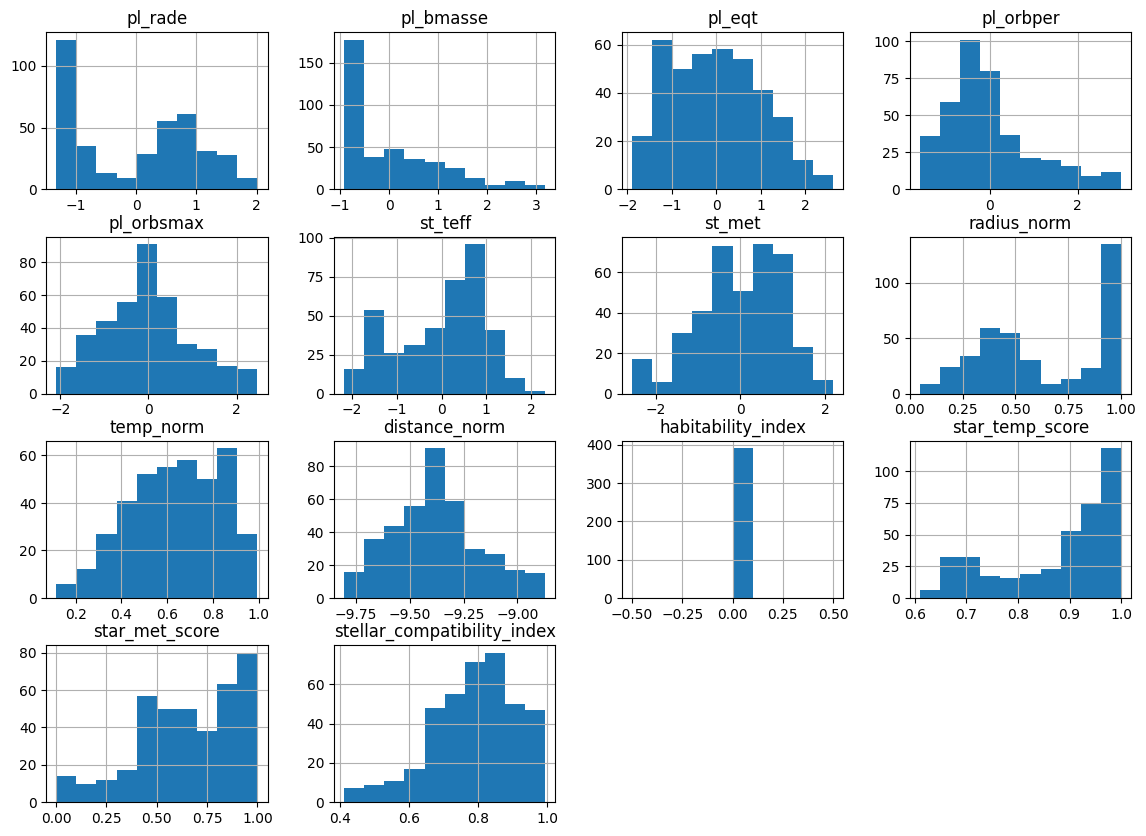

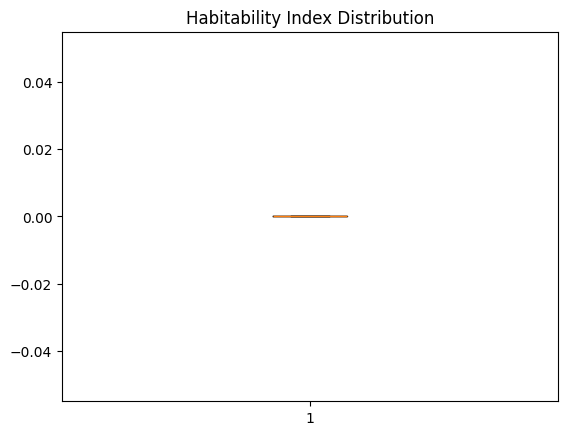

In [27]:
import matplotlib.pyplot as plt

# Statistics
print(df.describe())

# Histograms
df.hist(figsize=(14, 10))
plt.show()

# Boxplot for habitability
plt.boxplot(df["habitability_index"])
plt.title("Habitability Index Distribution")
plt.show()


**Save the final processed dataset**

In [30]:
df.to_csv("processed_exoplanet_features.csv", index=False)
print("Module 2 completed & dataset saved")


Module 2 completed & dataset saved
